Imports Libraries

In [141]:
import pandas as pd
from IPython.display import display
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



Loads Data Frame

In [163]:
with open("BTCUSD_10y_tagged.pickle", \
          "rb") as f:
      df \
      = pickle.load(f)

df = df.drop(['Volume','Low','Close','High'], axis=1)
df
#df.drop(df.tail(1).index,inplace=True)

,Open,sma7,sma25,sma99,bb_bbm,bb_bbh,bb_bbl,psar,MACD,RSI,sma40,Position
0,465.864014,465.864014,465.864014,465.864014,0.000000,0.000000,0.000000,457.334015,0.000000,100.000000,0.000000,0
1,456.859985,461.362000,461.362000,461.362000,0.000000,0.000000,0.000000,424.440002,-2.624024,0.000000,0.000000,0
2,424.102997,448.942332,448.942332,448.942332,0.000000,0.000000,0.000000,457.334015,-7.014744,0.000000,0.000000,0
3,394.673004,435.375000,435.375000,435.375000,0.000000,0.000000,0.000000,455.877975,-9.249402,20.155072,0.000000,1
4,408.084991,429.916998,429.916998,429.916998,0.000000,0.000000,0.000000,454.451056,-11.699137,17.448333,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2896,21531.462891,22589.500279,23279.442266,24184.880840,23202.340137,25201.415044,21203.265229,23637.872178,-277.320737,38.384527,22809.443652,0
2897,21401.044922,22200.201451,23181.675547,24084.847202,23123.327246,25270.532341,20976.122151,23415.380841,-334.667918,39.690429,22833.397852,0
2898,21526.455078,21863.792690,23090.861016,24000.645656,23057.239258,25312.872652,20801.605863,23210.688812,-386.399306,38.778672,22847.365137,1
2899,21395.458984,21585.852679,23000.596562,23909.443438,22995.670508,25359.559710,20631.781305,23022.372144,-406.102328,41.035597,22857.629834,0


In [166]:
df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)



df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)

X_train = df_train.drop('Position', axis=1)
X_valid = df_valid.drop('Position', axis=1)
y_train = df_train['Position']
y_valid = df_valid['Position']



Loads a model

In [164]:
model = tf.keras.models.load_model('Classifier_NN_hourly_v2.0')

# Check its architecture

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 8)                 96        
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


Creates a Model

In [168]:

model = keras.Sequential([
    layers.Dense(8, activation='relu', input_shape=[11]),
    layers.Dense(8, activation='relu'),    
    layers.Dense(1, activation='sigmoid'),
])

In [169]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

Trains a model

In [170]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=100,
    min_delta=0.001,
    restore_best_weights=True,
)



history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=2000,
    #callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)


In [171]:
score = model.evaluate(X_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.6290078163146973
Test accuracy: 0.6609195470809937


Best Validation Loss: 0.6263
Best Validation Accuracy: 0.6736


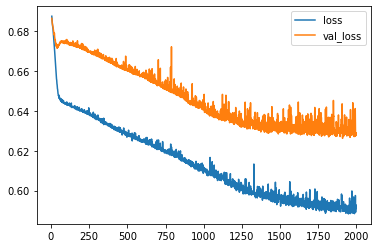

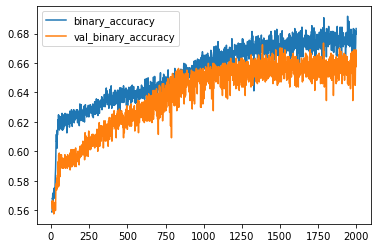

In [172]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [173]:
model.save('Classifier_NN_BTC_daily_v1.0')


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: Classifier_NN_BTC_daily_v1.0/assets


/Users/esteban/miniforge3/envs/tf_m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/Users/esteban/miniforge3/envs/tf_m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1397: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


In [128]:
import sklearn.naive_bayes
import sklearn.feature_extraction
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.metrics
import time
import sklearn.neighbors
import sklearn.ensemble
import sklearn.metrics
#pip install xgboost
import xgboost

In [129]:
# Creates a model

# Create naive bayes classifier
naive_bayes = sklearn.naive_bayes.MultinomialNB()

# Create a logistic regression classifier
logistic = sklearn.linear_model.LogisticRegression(solver='newton-cg',
                                                   tol=1e-2, max_iter=10000)

#Create a xgboost classifier
#xgboost = xgboost.XGBRFClassifier(alpha=1, max_depth=30)

# Create a k-Nearest neighbors classifier
kNN = sklearn.neighbors.KNeighborsClassifier(n_neighbors=150)

# Create a Random Forest classifier
randforest = sklearn.ensemble.RandomForestClassifier(n_estimators=1000,
    min_samples_leaf=0.003)


# Create a voting ensemble of classifiers
model = sklearn.ensemble.VotingClassifier(
    estimators=[('logistic', logistic),
                #('xgboost', xgboost),
                #('kNN', kNN),
                ('naive_bayes',naive_bayes),
                ('randforest', randforest),
                ],voting='soft')


# Train it with the training data and labels
model.fit(X_train, y_train)

# Predict
pred = model.predict(X_valid)


# Metrics
#

# Confusion matrix
cmatrix = sklearn.metrics.confusion_matrix(y_valid, pred)
print("Confusion Matrix:")
print(cmatrix)

# Accuracy, precision & recall
print("Accuracy:   {:.3f}".format(sklearn.metrics.accuracy_score(y_valid, pred)))
print("Precision:  {:.3f}".format(sklearn.metrics.precision_score(y_valid, pred, average='weighted')))
print("Recall:     {:.3f}".format(sklearn.metrics.recall_score(y_valid, pred, average='weighted')))



Confusion Matrix:
[[193 196]
 [138 349]]
Accuracy:   0.619
Precision:  0.615
Recall:     0.619
